# Анализ работы модели предсказания качества воздуха

В работе используются:
- Модель Air Quality Prediction ([Kaggle](https://www.kaggle.com/code/hamedetezadi/air-quality-prediction)), в формате [ноутбука](https://colab.research.google.com/drive/14Tlqrmg76i7S33Gc5P5iFvjh7Ml2dXxB?usp=sharing)
- Датасет  «СОСТОЯНИЕ ЗАГРЯЗНЕНИЯ АТМОСФЕРЫ В
 ГОРОДАХ РОССИИ C 2007 ГОДА» - взят с сайта [Если быть точным](https://tochno.st/datasets/air_cities)


# 1. Скачивание датасета

In [35]:
import os

import kagglehub

source_dataset_name = "shrutibhargava94/india-air-quality-data"
source_dataset_files_path = kagglehub.dataset_download(source_dataset_name)

print(f"Скачиваем исходный датасет {source_dataset_name}")
for filename in os.listdir(source_dataset_files_path):
    source = os.path.join(source_dataset_files_path, filename)
    if os.path.isfile(source):
        with open(source, 'rb') as src:
            content = src.read()

        with open(os.path.join("./data", filename), 'w') as dst:
            dst.write(content.decode('utf-8', errors='ignore'))

print(f"Исходный датасет {source_dataset_name} помещен в папку проекта data")

Скачиваем исходный датасет shrutibhargava94/india-air-quality-data
Исходный датасет shrutibhargava94/india-air-quality-data помещен в папку проекта data


Код автоматически загружает набор данных с платформы Kaggle и сохраняет его в локальной папке. Используются библиотеки kagglehub и os. После задания имени датасета выполняется его скачивание, а затем файлы считываются и записываются в директорию ./data.

Добавлены сообщения о процессе выполнения, позволяющие отслеживать этапы загрузки.

## 2. Импорт необходимых зависимостей

In [36]:
import pandas as pd
import numpy as np
import joblib as jl

## 3. Описание используемого датасета

Данные датасета приведены в соответствии с теми, что были использованы при построении исходной модели с kaggle.
* Поле type (тип местности, где был произведен замер) заполнено значением "Промышленные предприятия", т.к. все данные собраны по ним.
* Поле spm (взвешенные твердые частицы) заполненно значениями поля solid emissions исходного сета.
* Поле rspm (концентрация вдыхаемых взвешенных частиц) - значение поля spm умноженного на коэффциент 0,6 (выбран эмпирически).
* Поле pm2_5 (твердые частицы) не заполнено, в расчетах исходной модели роли не играет.

In [37]:
# данные датасета приведенные к требуемому виду для использования исходной моделью
data = pd.read_csv('data/upd_data_air_cities_100_v20231129_data_air_cities_100_v20231129.csv')
data.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,1701000,2007,Алтайский край,БАРНАУЛ,NaN,Промышленные предприятия,14.7,4.3,14.28,23.8,NaN,NaN,2007
1,1705000,2007,Алтайский край,БИЙСК,NaN,Промышленные предприятия,7.4,2.9,5.40,9.0,NaN,NaN,2007
2,1706000,2007,Алтайский край,ЗАРИНСК,NaN,Промышленные предприятия,4.8,2.4,1.74,2.9,NaN,NaN,2007
3,10701000,2007,Амурская область,БЛАГОВЕЩЕНСК,NaN,Промышленные предприятия,3.8,4.0,7.38,12.3,NaN,NaN,2007
4,10712000,2007,Амурская область,ЗЕЯ,NaN,Промышленные предприятия,0.3,0.2,0.24,0.4,NaN,NaN,2007


Код выполняет загрузку подготовленного датасета, приведенного к требуемому формату для работы с моделью. Для этого спользуется библиотека pandas, а файл данных считывается из директории data с помощью pd.read_csv().

После загрузки выполняется просмотр первых строк таблицы через data.head(), что позволяет убедиться в корректности загруженных данных: в таблице присутствуют такие столбцы, как stn_code, sampling_date, state, location, agency и type, содержащие информацию о коде станции, дате измерений, регионе, названии населенного пункта и типе измерения соответственно.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3992 entries, 0 to 3991
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   stn_code                     3992 non-null   int64  
 1   sampling_date                3992 non-null   int64  
 2   state                        3992 non-null   object 
 3   location                     3992 non-null   object 
 4   agency                       0 non-null      float64
 5   type                         3992 non-null   object 
 6   so2                          3991 non-null   float64
 7   no2                          3991 non-null   float64
 8   rspm                         3992 non-null   float64
 9   spm                          3991 non-null   float64
 10  location_monitoring_station  0 non-null      float64
 11  pm2_5                        0 non-null      float64
 12  date                         3992 non-null   int64  
dtypes: float64(7), int

Как можно увидеть по выводу info(), в наборе данных 13 столбцов, из которых три содержат текстовую информацию (object), три представлены в числовом формате (int64), а семь имеют тип float64.

Некоторые столбцы заполнены полностью (например: stn_code, sampling_date, state, location, type, rspm, date), что позволяет сразу использовать их в анализе. Однако есть поля, в которых отсутствуют все значения (agency, location_monitoring_station, pm2_5), а также несколько столбцов с частично пропущенными данными (so2, no2, spm).

## 4. Очистка исходных данных

Необходимо осуществить заменену в датафрейме определенных значений (-1 и -0.6) на пропущенные (NaN). Это помогает корректно обрабатывать отсутствующие данные при анализе и моделировании.

In [39]:
data.replace([-1, -0.6], np.nan, inplace=True)

## 5. Подготовка существующей модели

Ниже выполняется загрузка предобученной модели Air_Quality_Prediction.joblib и проверка соответствия входных данных ее ожидаемым признакам. Затем рассчитываются индексы загрязняющих веществ (SOi, Noi, Rpi, SPMi) на основе концентраций so2, no2, rspm и spm. После этого код проверяет, есть ли в данных все необходимые для модели признаки, и добавляет отсутствующие столбцы с заполнением нулями.
 В итоге формируется датафрейм data_final, содержащий только признаки, нужные для работы модели, с удалением NaN-значений.

In [40]:
# Загрузка существующей модели
model_name = "Air_Quality_Prediction.joblib"
model_path = f"model/{model_name}"
model = jl.load(model_path)

# Определяем ожидаемые признаки для модели
expected_features = model.feature_names_in_
print("Ожидаемые моделью признаки:", expected_features)
print("Текущие признаки:", data.columns.tolist())

def calculate_soi(so2):
    si = 0
    if so2 <= 40:
        si = so2 * (50 / 40)
    elif 40 < so2 <= 80:
        si = 50 + (so2 - 40) * (50 / 40)
    elif 80 < so2 <= 380:
        si = 100 + (so2 - 80) * (100 / 300)
    elif 380 < so2 <= 800:
        si = 200 + (so2 - 380) * (100 / 420)
    elif 800 < so2 <= 1600:
        si = 300 + (so2 - 800) * (100 / 800)
    elif so2 > 1600:
        si = 400 + (so2 - 1600) * (100 / 800)

    return si


def calculate_noi(no2):
    if no2 <= 40:
        ni = no2 * 50 / 40
    elif 40 < no2 <= 80:
        ni = 50 + (no2 - 40) * (50 / 40)
    elif 80 < no2 <= 180:
        ni = 100 + (no2 - 80) * (100 / 100)
    elif 180 < no2 <= 280:
        ni = 200 + (no2 - 180) * (100 / 100)
    elif 280 < no2 <= 400:
        ni = 300 + (no2 - 280) * (100 / 120)
    else:
        ni = 400 + (no2 - 400) * (100 / 120)

    return ni


def calculate_rpi(rspm):
    rpi = 0
    if rspm <= 30:
        rpi = rspm * 50 / 30
    elif 30 < rspm <= 60:
        rpi = 50 + (rspm - 30) * 50 / 30
    elif 60 < rspm <= 90:
        rpi = 100 + (rspm - 60) * 100 / 30
    elif 90 < rpi <= 120:
        rpi = 200 + (rspm - 90) * 100 / 30
    elif 120 < rpi <= 250:
        rpi = 300 + (rspm - 120) * (100 / 130)
    else:
        rpi = 400 + (rspm - 250) * (100 / 130)

    return rpi


def calculate_spi(spm):
    if spm <= 50:
        spi = spm * 50 / 50
    elif 50 < spm <= 100:
        spi = 50 + (spm - 50) * (50 / 50)
    elif 100 < spm <= 250:
        spi = 100 + (spm - 100) * (100 / 150)
    elif 250 < spm <= 350:
        spi = 200 + (spm - 250) * (100 / 100)
    elif 350 < spm <= 430:
        spi = 300 + (spm - 350) * (100 / 80)
    else:
        spi = 400 + (spm - 430) * (100 / 430)

    return spi

# Добавляем расчетные значения 'SOi' 'Noi' 'Rpi' 'SPMi'
data['SOi'] = data['so2'].apply(calculate_soi)
data['Noi'] = data['no2'].apply(calculate_noi)
data['Rpi'] = data['rspm'].apply(calculate_rpi)
data['SPMi'] = data['spm'].apply(calculate_spi)

# Подготавливаем список отсутствующих в наших данных признаков
missing_features = set(expected_features) - set(data.columns)
print("Отсутствующие признаки:", missing_features) if missing_features else print(
    "Отсутствующих для работы модели признаков нет")

# Добавляем отсутствующие признаки, заполняя их нулями
for feature in missing_features:
    data[feature] = 0

# Оставляем только нужные признаки для модели
data_final = data[list(expected_features)].copy()
# TODO убираю все NaN, не надо так, но думать некогда
data_final.dropna(inplace=True)
data_final.head()

Ожидаемые моделью признаки: ['SOi' 'Noi' 'Rpi' 'SPMi']
Текущие признаки: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']
Отсутствующих для работы модели признаков нет


,SOi,Noi,Rpi,SPMi
0,18.375,5.375,23.8,23.8
1,9.250,3.625,9.0,9.0
2,6.000,3.000,2.9,2.9
3,4.750,5.000,12.3,12.3
4,0.375,0.250,0.4,0.4


## 6. Использование модели для прогнозирования

Завершающим этапом выполняется прогнозирование на основе подготовленных данных - моделью выполняются предсказания на основе подготовленных данных, а результаты добавляются в новый столбец Predictions. Обновленный файл сохраняется в data/processed_data_air_quality.csv.

In [41]:
# Прогнозирование
predictions = model.predict(data_final)
data_final['Predictions'] = predictions

# Сохранение обработанных данных
processed_file_path = 'data/processed_data_air_quality.csv'
data_final.to_csv(processed_file_path, index=False)
print(f"Обработанные данные сохранены в {processed_file_path}")

Обработанные данные сохранены в data/processed_data_air_quality.csv


## 7. Анализ обработанных данных

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка обработанных данных
file_path = "data/processed_data_air_quality.csv"
data = pd.read_csv(file_path)

# Вывод информации о данных
print("Информация о данных:")
print(data.info())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SOi          3518 non-null   float64
 1   Noi          3518 non-null   float64
 2   Rpi          3518 non-null   float64
 3   SPMi         3518 non-null   float64
 4   Predictions  3518 non-null   float64
dtypes: float64(5)
memory usage: 137.6 KB
None


Для выполнения общей оценки работы модели было выполнено построение графиков.
В первую очередь, следует оценить в каких пределах обычно находятся предсказания модели, чтобы изучить распределение. В случае, если оно сильно смещено в одну сторону, модель может плохо работать с редкими случаями.

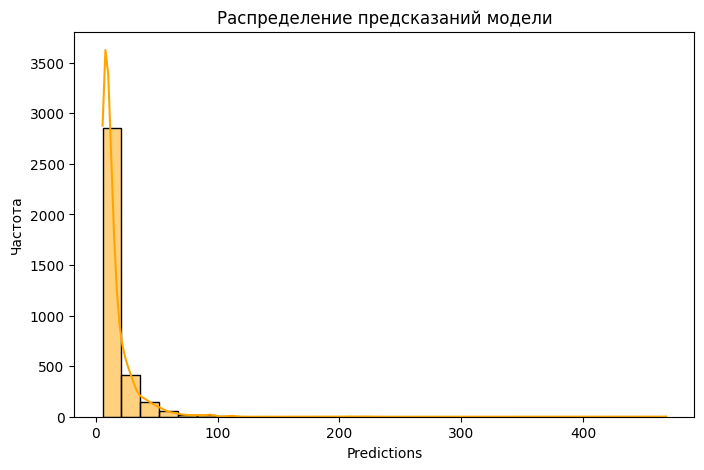

In [45]:
# Гистограмма распределения предсказаний
plt.figure(figsize=(8, 5))
sns.histplot(data['Predictions'], bins=30, kde=True, color="orange")
plt.title("Распределение предсказаний модели")
plt.xlabel("Predictions")
plt.ylabel("Частота")
plt.show()

По гистограмме можно заметить, что большинство предсказаний сосредоточено в диапазоне 0–50, а дальше их частота резко падает.
Есть редкие выбросы с предсказаниями выше 100, 200 и даже 400, что может указывать на экстремальные случаи в данных.

Следующим шагом можно выполнить построение графика для отслеживания корреляции между показателями и предсказаниями - это может быть полезным для проверки значимости параметров: если какой-то показатель оказывает слабое влияние, возможно, модель не учитывает его должным образом.

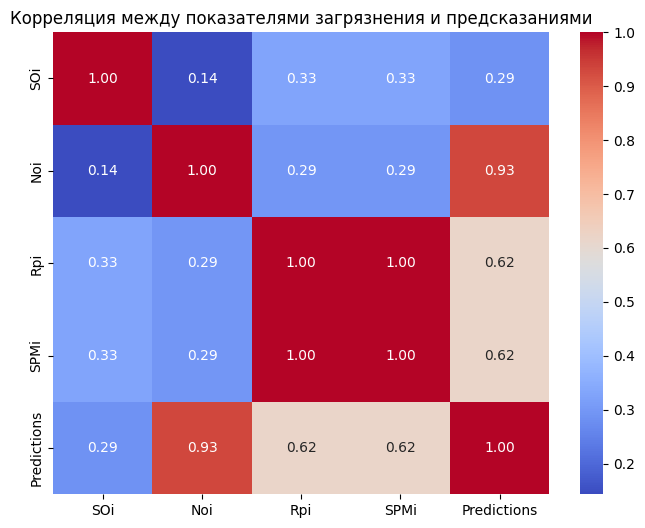

In [46]:
# Корреляция между показателями загрязнения и предсказаниями
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция между показателями загрязнения и предсказаниями")
plt.show()

По данному hitmap можно сделать следующие выводы:
1. Noi (индекс по NO₂) имеет сильную положительную корреляцию с Predictions (0.93). Это означает, что модель в основном ориентируется на уровень NO₂ при прогнозировании.
2. Rpi и SPMi также оказывают заметное влияние (0.62), но слабее.
3. SOi имеет слабую связь с предсказаниями (0.29), что может указывать на его меньшую значимость для модели.

### Проведение тестов

При анализе предсказаний модели важно убедиться, что модель работает стабильно и предсказания не сильно искажаются выбросами или особенностями данных. Чтобы проверить это, используются статистические тесты.

Перед выбором метода сравнения средних предсказаний нужно определить, как распределены данные. Если предсказания модели не распределены нормально, стандартные параметрические тесты (например, t-тест) могут давать некорректные результаты; также необходимо отследить
отличия дисперсий предсказаний в данных с выбросами и без (Levene’s test).
В зависимости от результатов можно применить t-тест (если нормальность и равные дисперсии) или U-тест Манна-Уитни (если данные не нормальны или дисперсии различны).

Этот подход позволяет объективно оценить поведение модели и понять, насколько сильно выбросы влияют на предсказания. Если обнаружится, что модель нестабильна, можно скорректировать предобработку данных или алгоритм предсказания.

In [54]:
from scipy import stats

# Оставляем только числовые данные
data_numeric = data.select_dtypes(include=["number"]).copy()

# Определение выбросов с использованием межквартильного размаха (IQR)
Q1 = data_numeric.quantile(0.25)
Q3 = data_numeric.quantile(0.75)
IQR = Q3 - Q1

# Создание столбца, указывающего на наличие выбросов (работаем только с числовыми данными)
data_numeric["Has_Outliers"] = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).any(axis=1)

# Выбор предсказанных значений в группах с выбросами и без
predictions_with_outliers = data_numeric.loc[data_numeric["Has_Outliers"], "Predictions"]
predictions_without_outliers = data_numeric.loc[~data_numeric["Has_Outliers"], "Predictions"]

# 1. Проверка нормальности предсказаний (Shapiro-Wilk test)
shapiro_stat_pred, shapiro_p_pred = stats.shapiro(data_numeric["Predictions"])
shapiro_stat_out, shapiro_p_out = stats.shapiro(predictions_with_outliers)
shapiro_stat_no_out, shapiro_p_no_out = stats.shapiro(predictions_without_outliers)

# 2. Проверка равенства дисперсий (Levene’s test)
levene_stat, levene_p = stats.levene(predictions_with_outliers, predictions_without_outliers)

# Вывод результатов тестов
print("### Результаты статистических тестов ###\n")

print(f"1. Тест Шапиро-Уилка (проверка нормальности предсказаний)")
print(f"   Полные данные: p = {shapiro_p_pred:.2e}")
print(f"   Данные с выбросами: p = {shapiro_p_out:.2e}")
print(f"   Данные без выбросов: p = {shapiro_p_no_out:.2e}")
if shapiro_p_pred < 0.05:
    print("Предсказания НЕ распределены нормально.\n")
else:
    print("Предсказания распределены нормально.\n")

print(f"2. Тест Левена (проверка равенства дисперсий)")
print(f"   p = {levene_p:.2e}")
if levene_p < 0.05:
    print("Дисперсии различаются. Выбросы вызывают нестабильность модели.\n")
else:
    print("Дисперсии равны. Выбросы не оказывают влияния на изменчивость модели.\n")


### Результаты статистических тестов ###

1. Тест Шапиро-Уилка (проверка нормальности предсказаний)
   Полные данные: p = 1.95e-71
   Данные с выбросами: p = 2.21e-39
   Данные без выбросов: p = 1.04e-42
Предсказания НЕ распределены нормально.

2. Тест Левена (проверка равенства дисперсий)
   p = 2.42e-118
Дисперсии различаются. Выбросы вызывают нестабильность модели.



В результате проведения проверок, можно сделать следующие выводы:
1. Так как предсказания не распределены нормально, применять t-тест нельзя.
2. При проверке дисперсии подтверждается, что предсказания в данных с выбросами имеют гораздо большую изменчивость, чем без них.

Выбросы сильно искажают предсказания модели - предсказания не распределены нормально, что может указывать на проблемы с качеством данных или переобучением модели;
дисперсия в данных с выбросами гораздо выше, что подтверждает нестабильность модели в экстремальных случаях.

Так как данные не нормальны и имеют разную дисперсию, следует применить статистический непараметрический U-тест Манна-Уитни.

U-тест Манна-Уитни используется для сравнения двух групп данных, в нашем случае мы хотим понять:

Есть ли статистически значимое различие между предсказаниями модели для данных с выбросами и без?
Сильно ли выбросы влияют на предсказания?
Если p-значение теста < 0.05, значит, различия значимы, и модель ведет себя по-разному в зависимости от наличия выбросов.

In [56]:
# Проведение U-теста Манна-Уитни (непараметрический тест)
u_stat, u_p_value = stats.mannwhitneyu(
    predictions_with_outliers,
    predictions_without_outliers,
    alternative="two-sided"
)

# Вывод результатов теста
print("### U-тест Манна-Уитни (сравнение предсказаний с выбросами и без) ###\n")
print(f"U-статистика: {u_stat:.2f}")
print(f"p-значение: {u_p_value:.2e}")

# Интерпретация результата
if u_p_value < 0.05:
    print("Различие предсказаний в данных с выбросами и без значимо.")
    print("   Модель работает по-разному в зависимости от наличия выбросов.\n")
else:
    print("Различие предсказаний незначимо.")
    print("   Выбросы не оказывают сильного влияния на предсказания модели.\n")

### U-тест Манна-Уитни (сравнение предсказаний с выбросами и без) ###

U-статистика: 2037685.00
p-значение: 0.00e+00
Различие предсказаний в данных с выбросами и без значимо.
   Модель работает по-разному в зависимости от наличия выбросов.



## Вывод
Значение U-статистики (2037685.00) говорит о том, что распределения предсказаний в данных с выбросами и без различаются.
p-значение = 0.00 (меньше 0.05) означает, что это различие статистически значимо.

Это может означать, что выбросы сильно влияют на предсказания, и модель нестабильна в экстремальных ситуациях.
Возможно, модель слишком чувствительна к редким или аномальным значениям.